In [14]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option("display.max_column", 999)

In [15]:
df_mvp = pd.read_excel('../collect-data/src/files/nba_data.xlsx', sheet_name='MVP')
df_mvp

,Unnamed: 0,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON
0,12971,2,Karl,Malone,NaN,UTA,33,82,64,18,2997.7,2249,864,1571,55.0,0,13,0.0,521,690,75.5,193,616,809,368,233,113,48,216,4022,43,1,767,1996-97
1,12531,1,Michael,Jordan,NaN,CHI,35,82,62,20,3182.4,2357,881,1893,46.5,30,126,23.8,565,721,78.4,130,345,475,283,185,141,45,151,3725,5,0,598,1997-98
2,12093,3,Karl,Malone,NaN,UTA,35,49,36,13,1831.6,1164,393,797,49.3,0,1,0.0,378,480,78.8,107,356,463,201,162,62,28,134,2129,21,1,354,1998-99
3,11652,1,Shaquille,O'Neal,NaN,LAL,28,79,66,13,3165.2,2344,956,1665,57.4,0,1,0.0,432,824,52.4,336,742,1078,299,223,36,239,255,4688,63,0,705,1999-00
4,11212,2,Allen,Iverson,NaN,PHI,26,71,50,21,2975.9,2207,762,1813,42.0,98,306,32.0,585,719,81.4,50,223,273,325,237,178,20,147,3379,4,0,371,2000-01
5,10772,2,Tim,Duncan,NaN,SAS,26,82,58,24,3331.7,2089,764,1504,50.8,1,10,10.0,560,701,79.9,268,774,1042,307,263,61,203,217,4329,67,0,561,2001-02
6,10348,6,Tim,Duncan,NaN,SAS,27,81,60,21,3182.4,1884,714,1392,51.3,6,22,27.3,450,634,71.0,259,784,1043,316,248,55,237,231,4238,58,1,554,2002-03
7,9901,1,Kevin,Garnett,NaN,MIN,28,82,58,24,3235.1,1987,804,1611,49.9,11,43,25.6,368,465,79.1,245,894,1139,409,212,120,178,202,4649,71,2,614,2003-04
8,9488,52,Steve,Nash,NaN,PHX,31,75,60,15,2568.6,1165,430,857,50.2,94,218,43.1,211,238,88.7,57,192,249,861,245,74,6,136,2750,49,1,664,2004-05
9,9007,29,Steve,Nash,NaN,PHX,32,79,54,25,2795.9,1489,541,1056,51.2,150,342,43.9,257,279,92.1,47,286,333,826,276,61,12,120,3071,43,1,472,2005-06


In [16]:
df_all = pd.read_excel('../collect-data/src/files/nba_data.xlsx', sheet_name='NBA Stats')
df_all.head()

,Unnamed: 0,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON
0,0,1,Luka,Doncic,NaN,DAL,25,63,40,23.0,2355.6,2137,727,1492.0,48.7,244,652.0,37.4,439,558.0,78.7,53,519,572,617,249,93,34,131,3881,43,19,222,2023-24
1,1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,70,50,20.0,2409.1,2131,756,1400.0,54.0,91,248.0,36.7,528,606.0,87.1,61,331,392,444,154,147,64,175,3746,8,0,553,2023-24
2,2,3,Giannis,Antetokounmpo,NaN,MIL,29,68,43,25.0,2393.9,2087,783,1272.0,61.6,34,118.0,28.8,487,741.0,65.7,182,598,780,435,234,81,69,199,3892,54,9,314,2023-24
3,3,4,Jayson,Tatum,NaN,BOS,26,68,53,15.0,2444.7,1858,627,1328.0,47.2,214,566.0,37.8,390,469.0,83.2,62,498,560,335,173,70,40,136,3190,24,0,599,2023-24
4,4,5,Jalen,Brunson,NaN,NYK,27,67,43,24.0,2342.4,1834,656,1376.0,47.7,179,446.0,40.1,343,406.0,84.5,38,204,242,436,161,61,13,125,2839,5,0,408,2023-24


# Feature Engineering

## Functions

***PCA***

In [17]:
def perform_pca(df, n_components, nominal_columns=[]):
    # Separate nominal columns from numerical columns
    numerical_columns = df.columns.difference(nominal_columns)
    nominal_data = df[nominal_columns]
    numerical_data = df[numerical_columns]
    
    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)
    
    # Apply PCA to numerical data
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Create a new DataFrame with the principal components
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Concatenate nominal data with principal components DataFrame
    if not nominal_data.empty:
        principal_df = pd.concat([nominal_data.reset_index(drop=True), principal_df], axis=1)
    
    return principal_df, cumulative_variance_ratio

***Entropy***

In [18]:
def entropy(feature):
    unique, counts = np.unique(feature, return_counts=True)
    probabilities = counts / len(feature)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

***Variance***

In [19]:
def variance(feature):
    mean = np.mean(feature)
    variance = np.mean((feature - mean) ** 2)
    return variance

## Execution

***Aggregation***

In [20]:
# df_mvp['PPG'] = df_mvp['PTS'] / df_mvp['GP'] # Points Per Game
# df_mvp['RPG'] = df_mvp['REB'] / df_mvp['GP'] # Rebounds Per Game
# df_mvp['APG'] = df_mvp['AST'] / df_mvp['GP'] # Assists Per Game
# df_mvp['SPG'] = df_mvp['STL'] / df_mvp['GP'] # Steals Per Game
# df_mvp['BPG'] = df_mvp['BLK'] / df_mvp['GP'] # Blocks Per Game
# df_mvp['PMPG'] = df_mvp['+/-'] / df_mvp['GP'] # Plus/Minus Per Game

# aggregated_to_remove = ['PTS', 'REB', 'AST', 'STL', 'BLK', '+/-']
# df_mvp = df_mvp.drop(columns=aggregated_to_remove)

***Deletion***

In [21]:
# features_to_remove = ['Unnamed: 0', 'SUFFIX', 'TEAM', 'AGE', 'MIN', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'TOV', 'PF', 'FP', 'SEASON']
# df_mvp = df_mvp.drop(columns=features_to_remove)
# df_mvp

In [22]:
# nominal_features = ['FIRST NAME', 'LAST NAME']
# pca, pca_var = perform_pca(df_mvp, 12, nominal_features)

# pca_var

In [23]:
nominal_features = ['FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM', 'SEASON']
pca, pca_var = perform_pca(df_mvp, 10, nominal_features)

pca_var

array([0.28970741, 0.51698311, 0.65119841, 0.75431803, 0.83398661,
       0.86975238, 0.90150486, 0.92750972, 0.94765908, 0.95945998])

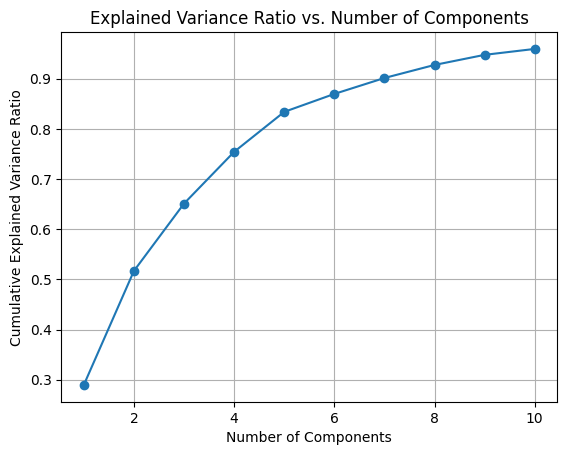

In [24]:
# Plot the cumulative explained variance ratio
plt.plot(range(1, len(pca_var) + 1), pca_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()